### Problem Statement

A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure and ICP transformation. Due to noise in wheel odometry it generated a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

In [94]:
%matplotlib inline
from gtsam import Pose2, Point2, Point3, Symbol, noiseModel, NonlinearFactorGraph, Values, BetweenFactorPose2, PriorFactorPose2, LevenbergMarquardtParams
from gtsam import *
import matplotlib.pyplot as plt
import math
import numpy as np
import os
from gtsam.utils import plot
import colorsys
from graphviz import Digraph
import graphviz
np.random.seed(0)

In [95]:
help(writeG2o)

Help on built-in function writeG2o in module gtsam.gtsam:

writeG2o(...) method of builtins.PyCapsule instance
    writeG2o(graph: gtsam.gtsam.NonlinearFactorGraph, estimate: gtsam.gtsam.Values, filename: str) -> None



Generating X, Y coordinates and $\theta$ separately for the trajectory

In [96]:
def get_distinct_colors(num_colors):
    colors = []
    for i in range(num_colors):
        hue = i / num_colors
        r, g, b = colorsys.hsv_to_rgb(hue, 1, 1)
        colors.append((r, g, b))
    return colors

def plot_positions_and_orientations(arr, labels=None, ax=None, fig=None):
    """
    Plot positions and orientations as arrows on a Matplotlib axes.

    Parameters:
    - arr: 2D array of shape (N, 3), where N is the number of positions.
           Each row contains [x, y, theta] where x and y are positions and theta is orientation.
    - labels: Optional list of labels for each position.

    Returns:
    - None
    """
    num_positions = len(arr)
    distinct_colors = get_distinct_colors(num_positions)
    if ax is None:
        fig, ax = plt.subplots()
    length_arrow = ((arr[:,0].max()**2 + arr[:,1].max()**2)**0.5)/100
    for i, (x, y, theta) in enumerate(arr):
        dx = np.cos(theta)
        dy = np.sin(theta)
        color = distinct_colors[i]
        ax.arrow(x, y, dx*0.05, dy*0.05, head_width=length_arrow, head_length=length_arrow, fc=color, ec=color, label=labels[i] if labels else None)
    for i in range(num_positions - 1):
        x1, y1, _ = arr[i]
        x2, y2, _ = arr[i + 1]
        plt.plot([x1, x2], [y1, y2], linestyle='dotted', color='gray')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    return fig, ax

# def plot_3d_positions_and_orientations(arr, labels=None, ax=None, fig=None):
#     """
#     Plot 3D positions and orientations as arrows on a 3D Matplotlib axes with nicely distinguishable random colors.

#     Parameters:
#     - arr: 2D array of shape (N, 12), where N is the number of positions.
#            Each row contains [R11, R12, R13, R21, R22, R23, R31, R32, R33, X, Y, Z]
#            representing the rotation matrix and 3D position.
#     - labels: Optional list of labels for each position.

#     Returns:
#     - None
#     """
#     num_positions = len(arr)
#     distinct_colors = get_distinct_colors(num_positions)
#     if ax is None or fig is None:
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection='3d')

#     for i, (r11, r12, r13, r21, r22, r23, r31, r32, r33, x, y, z) in enumerate(arr):
#         # Calculate orientation as a unit vector
#         rotation_mat = np.array([[r11, r12, r13], [r21, r22, r23], [r31, r32, r33]])
        
#         color = distinct_colors[i]
#         ax.quiver(x, y, z, orientation[0], orientation[1], orientation[2], color=color, label=labels[i] if labels else None)

#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     ax.legend()
#     return ax, fig

In [97]:
def genTraj():
    init = (0, 0)

    # Forward I
    num = 20; xSt = -5; ySt = -8; leng = 9.0; step = float(leng)/num
    X1 = np.zeros(num); Y1 = np.zeros(num); X1[0] = xSt; Y1[0] = ySt
    for i in range(1, num):
        X1[i] = X1[i-1] + step
        Y1[i] = ySt

    # UTurn I
    rad = 2.5; num = 20
    xCen = X1[-1]; yCen = Y1[-1] + rad
    thetas = np.linspace(-math.pi/2, math.pi/2, num)
    X2 = np.zeros(num); Y2 = np.zeros(num)
    for i, theta in enumerate(thetas):
        X2[i] = (xCen + rad*math.cos(theta))
        Y2[i] = (yCen + rad*math.sin(theta))

    # Backward I
    num = 20; leng = 10.0; step = float(leng)/num
    xSt = X2[-1]; ySt = Y2[-1]
    X3 = np.zeros(num); Y3 = np.zeros(num); X3[0] = xSt; Y3[0] = ySt 
    for i in range(1, num):
        X3[i] = X3[i-1] - step
        Y3[i] = ySt

    # UTurn II
    rad = 2.6; num = 20
    xCen = X3[-1]; yCen = Y3[-1] - rad
    thetas = np.linspace(math.pi/2, 3*math.pi/2, num)
    X4 = np.zeros(num); Y4 = np.zeros(num)
    for i, theta in enumerate(thetas):
        X4[i] = (xCen + rad*math.cos(theta))
        Y4[i] = (yCen + rad*math.sin(theta))

    # Forward II
    num = 20; leng = 11.0; step = float(leng)/num
    xSt = X4[-1]; ySt = Y4[-1]
    X5 = np.zeros(num); Y5 = np.zeros(num); X5[0] = xSt; Y5[0] = ySt
    for i in range(1, num):
        X5[i] = X5[i-1] + step
        Y5[i] = ySt

    # UTurn III
    rad = 2.7; num = 20
    xCen = X5[-1]; yCen = Y5[-1] + rad
    thetas = np.linspace(-math.pi/2, math.pi/2, num)
    X6 = np.zeros(num); Y6 = np.zeros(num)
    for i, theta in enumerate(thetas):
        X6[i] = (xCen + rad*math.cos(theta))
        Y6[i] = (yCen + rad*math.sin(theta))	

    # Assemble
    X = np.concatenate([X1, X2, X3, X4, X5, X6]); Y = np.concatenate([Y1, Y2, Y3, Y4, Y5, Y6])
    THETA = np.array(getTheta(X, Y))

    return (X, Y, THETA)


def getTheta(X ,Y):
    THETA = [None]*len(X)
    for i in range(1, len(X)-1):
        if(X[i+1] == X[i-1]):
            if (Y[i+1]>Y[i-1]):
                THETA[i] = math.pi/2
            else:
                THETA[i] = 3*math.pi/2
            continue

        THETA[i] = math.atan((Y[i+1]-Y[i-1])/(X[i+1]-X[i-1]))

        if(X[i+1]-X[i-1] < 0):
            THETA[i] += math.pi 

    if X[1]==X[0]:
        if Y[1] > Y[0]:
            THETA[0] = math.pi/2
        else:
            THETA[0] = 3*math.pi/2
    else:
        THETA[0] = math.atan((Y[1]-Y[0])/(X[1]-X[0]))

    if X[-1] == X[len(Y)-2]:
        if Y[1] > Y[0]:
            THETA[-1] = math.pi/2
        else:
            THETA[-1] = 3*math.pi/2
    else:
        THETA[-1] = math.atan((Y[-1]-Y[len(Y)-2])/(X[-1]-X[len(Y)-2]))

    return THETA

In [98]:
(X, Y, THETA) = genTraj()

Drawing functions for plotting one, two and three trajectories simultaneously.

In [99]:
def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'k-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'm->')

    plt.show()


def drawTwo(X1, Y1, THETA1, X2, Y2, THETA2):
    ax = plt.subplot(111)
    ax.plot(X1, Y1, 'ro', label='Ground Truth')
    plt.plot(X1, Y1, 'k-')

    for i in range(len(THETA1)):
        x2 = 0.25*math.cos(THETA1[i]) + X1[i]
        y2 = 0.25*math.sin(THETA1[i]) + Y1[i]
        plt.plot([X1[i], x2], [Y1[i], y2], 'r->')

    ax.plot(X2, Y2, 'bo', label='Optimized')
    plt.plot(X2, Y2, 'k-')

    for i in range(len(THETA2)):
        x2 = 0.25*math.cos(THETA2[i]) + X2[i]
        y2 = 0.25*math.sin(THETA2[i]) + Y2[i]
        plt.plot([X2[i], x2], [Y2[i], y2], 'b->')

    plt.legend()
    plt.show()


def drawThree(X1, Y1, THETA1, X2, Y2, THETA2, X3, Y3, THETA3):
    ax = plt.subplot(111)
    ax.plot(X1, Y1, 'ro', label='Ground Truth')
    plt.plot(X1, Y1, 'k-')

    for i in range(len(THETA1)):
        x2 = 0.25*math.cos(THETA1[i]) + X1[i]
        y2 = 0.25*math.sin(THETA1[i]) + Y1[i]
        plt.plot([X1[i], x2], [Y1[i], y2], 'r->')

    ax.plot(X2, Y2, 'bo', label='Optimized')
    plt.plot(X2, Y2, 'k-')

    for i in range(len(THETA2)):
        x2 = 0.25*math.cos(THETA2[i]) + X2[i]
        y2 = 0.25*math.sin(THETA2[i]) + Y2[i]
        plt.plot([X2[i], x2], [Y2[i], y2], 'b->')

    ax.plot(X3, Y3, 'go', label='Noisy')
    plt.plot(X3, Y3, 'k-')

    for i in range(len(THETA3)):
        x2 = 0.25*math.cos(THETA3[i]) + X3[i]
        y2 = 0.25*math.sin(THETA3[i]) + Y3[i]
        plt.plot([X3[i], x2], [Y3[i], y2], 'g->')

    plt.legend()
    plt.show()	


Ground Truth Trajectory

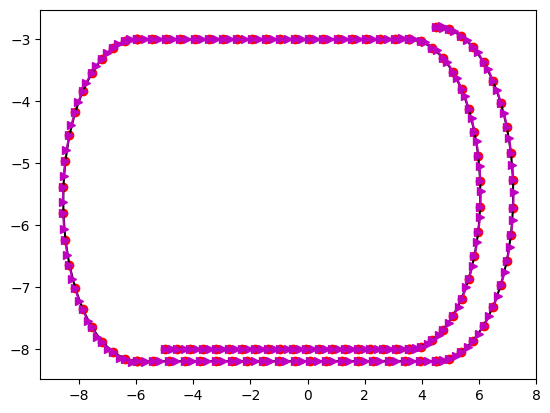

In [100]:
draw(X, Y, THETA)

Adding noise to the trajectory to simulate real life scenario.  
We could not directly add noise values to $X, Y, \theta$ parameters. Instead noise should be added to the odometry values.  
T1_w = $T^w_1$ = 1 with respect to the world

In [101]:
def addNoise(X, Y, THETA):
    xN = np.zeros(len(X)); yN = np.zeros(len(Y)); tN = np.zeros(len(THETA))
    xN[0] = X[0]; yN[0] = Y[0]; tN[0] = THETA[0]

    for i in range(1, len(X)):
        # Get T2_1
        p1 = (X[i-1], Y[i-1], THETA[i-1])
        p2 = (X[i], Y[i], THETA[i])
        T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
        T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
        del_x = T2_1[0][2]
        del_y = T2_1[1][2]
        del_theta = math.atan2(T2_1[1, 0], T2_1[0, 0])

        # Add noise
        if(i<5):
            xNoise = 0; yNoise = 0; tNoise = 0
        else:
            xNoise = np.random.normal(0, 0.03); yNoise = np.random.normal(0, 0.03); tNoise = np.random.normal(0, 0.03)
        del_xN = del_x + xNoise; del_yN = del_y + yNoise; del_thetaN = del_theta + tNoise

        # Convert to T2_1'
        T2_1N = np.array([[math.cos(del_thetaN), -math.sin(del_thetaN), del_xN], [math.sin(del_thetaN), math.cos(del_thetaN), del_yN], [0, 0, 1]])

        # Get T2_w' = T1_w' . T2_1'
        p1 = (xN[i-1], yN[i-1], tN[i-1])
        T1_wN = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_wN = np.dot(T1_wN, T2_1N)

        # Get x2', y2', theta2'
        x2N = T2_wN[0][2]
        y2N = T2_wN[1][2]
        theta2N = math.atan2(T2_wN[1, 0], T2_wN[0, 0])

        xN[i] = x2N; yN[i] = y2N; tN[i] = theta2N  

    # tN = getTheta(xN, yN)

    return (xN, yN, tN)

Noisy trajectory

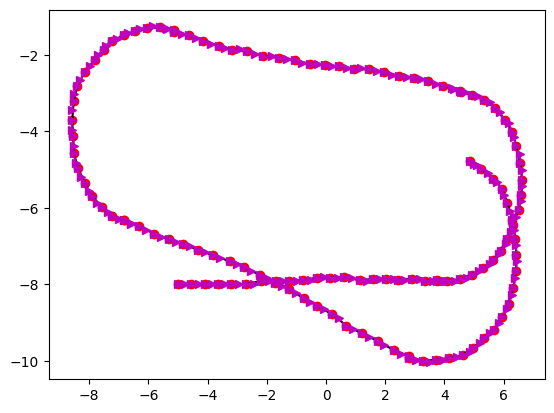

In [102]:
(xN, yN, tN) = addNoise(X, Y, THETA)
draw(xN, yN, tN)

Generating G2O file. We would be using `VERTEX_SE2` and `EDGE_SE2` for our task.  
Information matrix for odometry edges, $\omega_{odom}$ = `500.0 0.0 0.0 500.0 0.0 500.0`   
Information matrix for loop closure edges, $\omega_{lc}$ = `700.0 0.0 0.0 700.0 0.0 700.0`  
Loop closure constraints are generated for the starting part of the trajectory. In practice, they would be detected by loop closure system using bag of visual words and transformation would be calculated using ICP.  
Fix the starting node in pose graph otherwise the optimized pose graph can occur anywhere on cartesian plane.  
Below figure is generated using `g2o_viewer`, in terminal after generating `noise.g2o`, run: `g2o_viewer noise.g2o`  
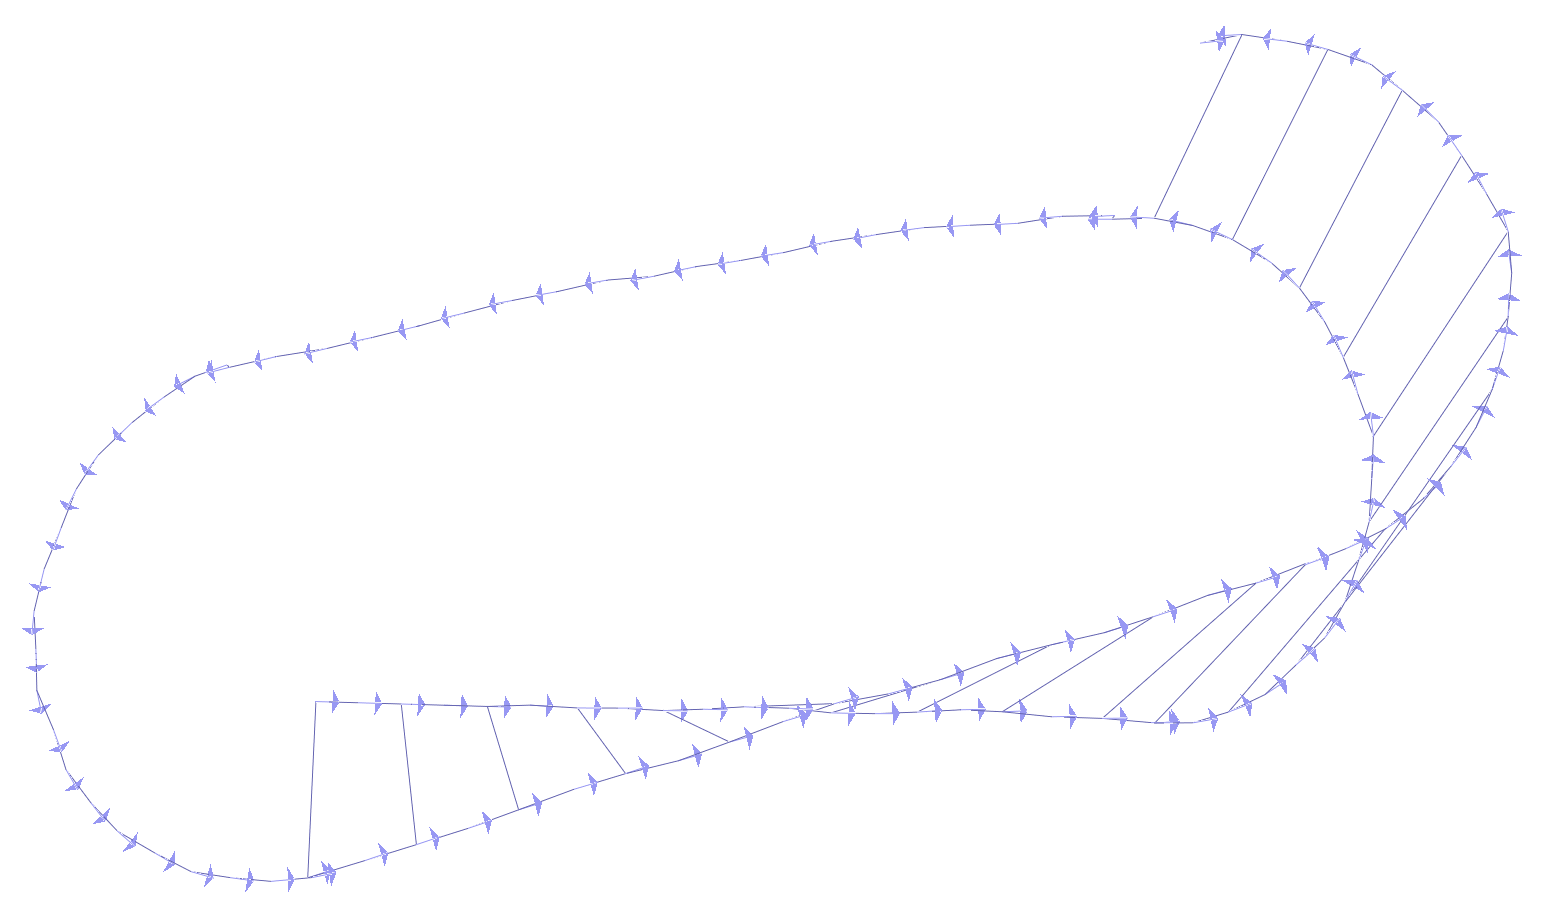



In [103]:
graph = NonlinearFactorGraph()
values = Values()

def writeOdom(X, Y, THETA):
    g2o = open('noise.g2o', 'w')

    for i, (x, y, theta) in enumerate(zip(X,Y,THETA)):
        line = "VERTEX_SE2 " + str(i) + " " + str(x) + " " + str(y) + " " + str(theta)
        g2o.write(line)
        g2o.write("\n")

    info_mat = "500.0 0.0 0.0 500.0 0.0 500.0"

    for i in range(1, len(X)):
        p1 = (X[i-1], Y[i-1], THETA[i-1])
        p2 = (X[i], Y[i], THETA[i])
        T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
        T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
        del_x = str(T2_1[0][2])
        del_y = str(T2_1[1][2])
        del_theta = str(math.atan2(T2_1[1, 0], T2_1[0, 0]))

        line = "EDGE_SE2 "+str(i-1)+" "+str(i)+" "+del_x+" "+del_y+" "+del_theta+" "+info_mat
        g2o.write(line)
        g2o.write("\n")

    g2o.write("FIX 0")
    g2o.write("\n")
    # g2o.close()
    return g2o

def writeOdomToGtsam(X, Y, THETA, graph, values):
    graph.add(PriorFactorPose2(0, Pose2(X[0], Y[0], THETA[0]), noiseModel.Diagonal.Sigmas(np.array([0.0, 0.0, 0.0]))))
    values.insert(0, Pose2(X[0], Y[0], THETA[0]))
    pose = Pose2(X[0], Y[0], THETA[0])
    for i, (x, y, theta) in enumerate(zip(X,Y,THETA)):
        if i > 0:
            pose_prev = pose
            pose = Pose2(x, y, theta)
            graph.add(BetweenFactorPose2(i-1, i, pose_prev.inverse()*pose, noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.1]))))
            values.insert(i, Pose2(x, y, theta))
        print(i, i+1, x, y, theta)

def writeLooptoGtsam(X, Y, THETA, graph, values):
    s2 = X.size
    pairs = []
    for i in range(0, 40, 2):
        pairs.append((i, i+80))
    
    for p in pairs:
        p1 = (X[p[0]], Y[p[0]], THETA[p[0]])
        p2 = (X[p[1]], Y[p[1]], THETA[p[1]])
        T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
        T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
        del_x = T2_1[0][2]
        del_y = T2_1[1][2]
        del_theta = math.atan2(T2_1[1, 0], T2_1[0, 0])

        graph.add(BetweenFactorPose2(p[0], p[1], Pose2(del_x, del_y, del_theta), noiseModel.Diagonal.Sigmas(np.array([0.01, 0.01, 0.01]))))
        print(p[0], p[1], del_x, del_y, del_theta)


def writeLoop(X, Y, THETA, g2o):
    sz = X.size

    pairs = []
    for i in range(0, 40, 2):
        pairs.append((i, i+80))
    # for i in range(len(X)):
    # 	pairs.append((0, i))

    info_mat = "700.0 0.0 0.0 700.0 0.0 700.0"

    for p in pairs:
        p1 = (X[p[0]], Y[p[0]], THETA[p[0]])
        p2 = (X[p[1]], Y[p[1]], THETA[p[1]])
        T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
        T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
        del_x = str(T2_1[0][2])
        del_y = str(T2_1[1][2])
        del_theta = str(math.atan2(T2_1[1, 0], T2_1[0, 0]))

        line = "EDGE_SE2 "+str(p[0])+" "+str(p[1])+" "+del_x+" "+del_y+" "+del_theta+" "+info_mat
        g2o.write(line)
        g2o.write("\n")

    g2o.close()

In [104]:
writeOdomToGtsam(xN, yN, tN, graph=graph, values=values)
writeLooptoGtsam(X, Y, THETA, graph=graph, values=values)

#optimize
from gtsam import LevenbergMarquardtOptimizer
params = LevenbergMarquardtParams()
params.setVerbosity('ERROR')
optimizer = LevenbergMarquardtOptimizer(graph, values, params)
result = optimizer.optimize()
# result.print()
graph.print()

0 1 -5.0 -8.0 0.0
1 2 -4.55 -8.0 0.0
2 3 -4.1 -8.0 0.0
3 4 -3.6499999999999995 -8.0 0.0
4 5 -3.1999999999999993 -8.0 0.0
5 6 -2.6970784296209693 -7.987995283748983 0.029362139523172175
6 7 -2.181719405930541 -7.916807990371524 4.380312687984198e-05
7 8 -1.7032165549662581 -7.921327746703704 -0.0030527624269268932
8 9 -1.2408875622562348 -7.918417804395122 0.04057544278196235
9 10 -0.7685936736778751 -7.895590489696219 0.053891339764325114
10 11 -0.3116656492789698 -7.826054620475686 0.04773659185135109
11 12 0.14842573806509396 -7.829726821767601 -0.02885310262367126
12 13 0.6185869807424909 -7.81735231369175 -0.05111805323586452
13 14 1.1337735054160423 -7.887398645888101 -0.04974529771682114
14 15 1.5798947810040684 -7.863569075196907 -0.0056645346198125925
15 16 2.0346001727501735 -7.85479973957761 -0.032298107048715975
16 17 2.4246355297109807 -7.877844336327587 -0.027607637975596573
17 18 2.9123544249956588 -7.855227378623124 -0.03922744249783514
18 19 3.351712490350757 -7.9039519


Factor 31: BetweenFactor(30,31)
  measured:  (0.4021399, 0.0357817018, 0.130392487)
isotropic dim=3 sigma=0.1

Factor 32: BetweenFactor(31,32)
  measured:  (0.43851127, 0.0480666147, 0.119259671)
isotropic dim=3 sigma=0.1

Factor 33: BetweenFactor(32,33)
  measured:  (0.456134042, 0.0909734168, 0.200710369)
isotropic dim=3 sigma=0.1

Factor 34: BetweenFactor(33,34)
  measured:  (0.406088731, 0.00197416285, 0.196980534)
isotropic dim=3 sigma=0.1

Factor 35: BetweenFactor(34,35)
  measured:  (0.399391167, 0.0707700936, 0.171595231)
isotropic dim=3 sigma=0.1

Factor 36: BetweenFactor(35,36)
  measured:  (0.440785647, 0.0447877334, 0.186544177)
isotropic dim=3 sigma=0.1

Factor 37: BetweenFactor(36,37)
  measured:  (0.411801476, 0.0876728563, 0.169154345)
isotropic dim=3 sigma=0.1

Factor 38: BetweenFactor(37,38)
  measured:  (0.423546157, 0.0905912624, 0.12491421)
isotropic dim=3 sigma=0.1

Factor 39: BetweenFactor(38,39)
  measured:  (0.373371926, 0.0631786427, 0.0474797887)
isotropic d

In [105]:
dir(Pose2)

['Adjoint',
 'AdjointMap',
 'Align',
 'Expmap',
 'ExpmapDerivative',
 'Identity',
 'Logmap',
 'LogmapDerivative',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'adjointMap_',
 'adjointTranspose',
 'adjoint_',
 'bearing',
 'between',
 'compose',
 'deserialize',
 'equals',
 'inverse',
 'localCoordinates',
 'logmap',
 'matrix',
 'print',
 'range',
 'retract',
 'rotation',
 'serialize',
 'theta',
 'transformFrom',
 'transformTo',
 'translation',
 'wedge',
 'x',
 'y']

In [106]:
X_gtsam_opt = []
Y_gtsam_opt = []
THETA_gtsam_opt = []

for key in result.keys():
    # print(key, result.atPose2(key).x(), result.atPose2(key).y(), result.atPose2(key).theta())
    X_gtsam_opt.append(result.atPose2(key).x())
    Y_gtsam_opt.append(result.atPose2(key).y())
    THETA_gtsam_opt.append(result.atPose2(key).theta())

# arr_opt = gtsam.utilities.extractPose2(result)
# for opt_mes in arr_opt:
#     X_gtsam_opt.append(opt_mes[0])
#     Y_gtsam_opt.append(opt_mes[1])
#     THETA_gtsam_opt.append(opt_mes[2])
print(len(X_gtsam_opt))

120


In [107]:
g2o = writeOdom(xN, yN, tN)
writeLoop(X, Y, THETA, g2o)

Optimize the pose graph using g2o binary and loads the optimized graph.  
G2O provides options to change the number of iteration steps, change the optimization solver and incorporate robust cost functions to minimize the impact of false loop closure constraints due to error in frontend.  

In [108]:
def optimize():
    cmd = "g2o -o opt.g2o noise.g2o"
    os.system(cmd)
    

def readG2o(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    X = []
    Y = []
    THETA = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split(' ')
            X.append(float(x))
            Y.append(float(y))
            THETA.append(float(theta.rstrip('\n')))

    return (X, Y, THETA)

Comparing Ground Truth and optimized trajectory.  

In [109]:
# optimize()
# (xOpt, yOpt, tOpt) = readG2o("opt.g2o")
drawTwo(X, Y, THETA, X_gtsam_opt, Y_gtsam_opt, THETA_gtsam_opt)

Comparing Ground Truth, optimized and noisy trajectory.  

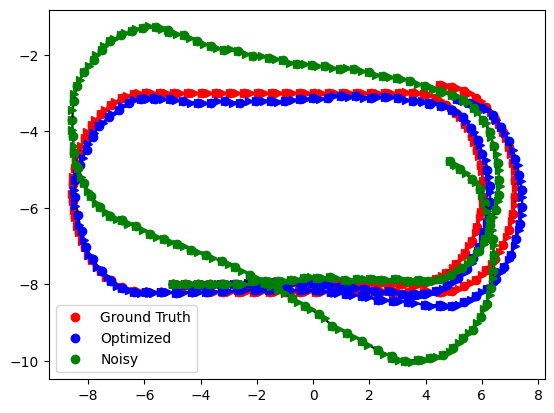

In [ ]:
drawThree(X, Y, THETA, X_gtsam_opt, Y_gtsam_opt, THETA_gtsam_opt, xN, yN, tN)

In [ ]:
writeG2o(graph, values, "graph.g2o")

In [ ]:
print(readG2o(fileName="graph.g2o"))

([-5.0, -4.55, -4.1, -3.65, -3.2, -2.69708, -2.18172, -1.70322, -1.24089, -0.768594, -0.311666, 0.148426, 0.618587, 1.13377, 1.57989, 2.0346, 2.42464, 2.91235, 3.35171, 3.75397, 3.73725, 4.10177, 4.52277, 4.91658, 5.30455, 5.63332, 5.89397, 6.10902, 6.3042, 6.50181, 6.60044, 6.61603, 6.56664, 6.42072, 6.28995, 6.0301, 5.7145, 5.34162, 4.92951, 4.56089, 4.51041, 3.96341, 3.45672, 2.96824, 2.47565, 1.97213, 1.43809, 0.947996, 0.440406, -0.0378801, -0.557309, -1.06285, -1.57096, -2.14123, -2.66175, -3.16112, -3.62672, -4.14129, -4.60938, -5.12868, -5.14656, -5.60487, -6.04591, -6.43845, -6.83272, -7.22374, -7.51094, -7.80699, -8.14727, -8.39485, -8.52142, -8.56953, -8.54109, -8.51367, -8.36882, -8.1431, -7.9013, -7.57302, -7.21198, -6.81398, -6.81045, -6.30377, -5.8046, -5.30912, -4.83699, -4.32735, -3.80778, -3.24216, -2.76004, -2.2443, -1.71285, -1.23921, -0.756918, -0.304698, 0.200602, 0.686558, 1.20982, 1.73909, 2.29862, 2.80707, 2.81267, 3.2742, 3.71643, 4.16003, 4.61623, 4.97999, 5.